# 1. Import Libraries

In [ ]:
# import system libs
import os

# from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# import Deep learning Libraries
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.layers import Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, classification_report

# import VGG16 requirements
from tensorflow.keras import Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential

import warnings
warnings.filterwarnings("ignore")

# 2. Helper Functions


In [ ]:
def train_and_evaluate_model(model, train_gen, valid_gen, test_gen, augmentation_type, epochs=50):
    """
    Train model and visualize results for a specific augmentation strategy
    """
    history = model.fit(
        train_gen,
        validation_data=valid_gen,
        epochs=epochs,
        verbose=1
    )

    # plot and get metrics
    metrics = plot_training_history(history, augmentation_type)

    # get precision and recall
    predicted_classes, true_classes = get_predictions(model, test_gen)
    precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')

    metrics.update({
        'test_precision': precision,
        'test_recall': recall,
        'test_f1': f1
    })

    return history, metrics


In [ ]:
def plot_training_history(history, augmentation_type):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch = {str(index_loss + 1)}'
    acc_label = f'best epoch = {str(index_acc + 1)}'

    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title(f'{augmentation_type} Augmentation - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title(f'{augmentation_type} Augmentation - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    metrics = {
        'best_val_loss': val_lowest,
        'best_val_loss_epoch': index_loss + 1,
        'best_val_acc': acc_highest,
        'best_val_acc_epoch': index_acc + 1
    }

    return metrics


In [ ]:
def get_predictions(model, generator):
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = generator.classes
    return predicted_classes, true_classes

# def evaluate_model(model, generator, class_names):
#     predicted_classes, true_classes = get_predictions(model, generator)

#     # get detailed metrics
#     precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes)

#     # print classification report
#     print(classification_report(true_classes, predicted_classes, target_names=class_names))

#     return precision, recall, f1, support

In [ ]:
def confusion_matrix_plot(test_gen, y_predict):
  y_pred = np.argmax(y_predict, axis=1)

  # get class indices and labels
  class_indices = test_gen.class_indices
  classes = list(class_indices.keys())

  # compute confusion matrix
  cm = confusion_matrix(test_gen.classes, y_pred)

  plt.figure(figsize=(10, 10))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.colorbar()

  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  threshold = cm.max() / 2.0
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(
          j, i, f"{cm[i, j]}",
          horizontalalignment='center',
          color='white' if cm[i, j] > threshold else 'black'
      )

  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()

# 3. Load Data

## 3.1 Loading from Kaggle

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
andrewmvd_lung_and_colon_cancer_histopathological_images_path = kagglehub.dataset_download('andrewmvd/lung-and-colon-cancer-histopathological-images')

print('Data source import complete.')


100%|██████████| 1.76G/1.76G [00:12<00:00, 147MB/s]

Extracting files...


Data source import complete.


In [ ]:
print(andrewmvd_lung_and_colon_cancer_histopathological_images_path)

/root/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1


In [ ]:
print(os.listdir(andrewmvd_lung_and_colon_cancer_histopathological_images_path))

['lung_colon_image_set']


## 3.2 Joining Images

In [ ]:
data_dir = '/root/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1/lung_colon_image_set'

file_paths = []
labels = []

folders = os.listdir(data_dir)

for folder in folders:
    sub_folder_path = os.path.join(data_dir, folder)
    sub_folder = os.listdir(sub_folder_path)

    for sfolder in sub_folder:
        s_sub_folder_path = os.path.join(sub_folder_path, sfolder)
        file_list = os.listdir(s_sub_folder_path)

        for file in file_list:
            fpath = os.path.join(s_sub_folder_path, file)

            file_paths.append(fpath)
            labels.append(sfolder)


FSeries = pd.Series(file_paths, name='filepaths')
LSeries = pd.Series(labels, name='labels')

df = pd.concat([FSeries, LSeries], axis=1)

## 3.3 Split Data

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['labels'])

valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['labels'])

# 4. Preprocessing

## 4.1 Helper Function

In [ ]:
# Function to create data generators for each augmentation pipeline
def create_data_generators(train_df, valid_df, test_df, augmentation_pipeline):
    train_generator = augmentation_pipeline.flow_from_dataframe(
        dataframe=train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )

    # Validation and test generators use only rescaling
    valid_test_generator = ImageDataGenerator(rescale=1./255)

    valid_generator = valid_test_generator.flow_from_dataframe(
        dataframe=valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = valid_test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='filepaths',
        y_col='labels',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, valid_generator, test_generator

## 4.2 Data Augmentation

In [ ]:
# Define image size and batch size
IMG_SIZE = 224  # Standard size for many CNN architectures
BATCH_SIZE = 32

### 4.2.1 Basic Augmentation

In [ ]:
# Basic Augmentation Pipeline
# Focuses on basic geometric transformations
basic_augmentation = ImageDataGenerator(
    rescale=1./255
)

# Create generators for each augmentation pipeline
basic_train_gen, basic_valid_gen, basic_test_gen = create_data_generators(
    train_df, valid_df, test_df, basic_augmentation)

Found 17500 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.


### 4.2.2 Moderate Augmentation

In [ ]:
# Moderate Augmentation Pipeline
# Adds intensity transformations while preserving tissue characteristics
moderate_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True
)

moderate_train_gen, moderate_valid_gen, moderate_test_gen = create_data_generators(
    train_df, valid_df, test_df, moderate_augmentation)


Found 17500 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.


### 4.2.3 Advanced Augmentation

In [ ]:
# Advanced Augmentation Pipeline
# Includes color transformations suitable for histopathology
advanced_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=3,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    vertical_flip=True
)

advanced_train_gen, advanced_valid_gen, advanced_test_gen = create_data_generators(
    train_df, valid_df, test_df, advanced_augmentation
)

Found 17500 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.


# 5. Model Initialization

 ## 5.1 VGG16 Model

In [ ]:
def create_model():
  img_size = (224, 224)
  channels = 3
  img_shape = (img_size[0], img_size[1], channels)
  class_count = len(list(basic_train_gen.class_indices.keys()))

  # load VGG16 without top layers
  base_model = VGG16(include_top=False, input_shape=img_shape)

  # custom classification layers
  x = Flatten()(base_model.output)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.3)(x)
  output = Dense(class_count, activation='softmax')(x)

  model = Model(inputs=base_model.input, outputs=output)
  model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()

  return model

## 5.2 Model Training

### 5.2.1 Training Basic Augmentation

In [ ]:
model_basic = create_model()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,154,245 (80.70 MB)

 Trainable params: 21,154,245 (80.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 114s 176ms/step - accuracy: 0.4059 - loss: 1.3509 - val_accuracy: 0.7616 - val_loss: 0.6347
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 77s 141ms/step - accuracy: 0.7614 - loss: 0.5677 - val_accuracy: 0.8757 - val_loss: 0.3718
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 76s 138ms/step - accuracy: 0.8688 - loss: 0.3709 - val_accuracy: 0.9331 - val_loss: 0.2091
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 76s 139ms/step - accuracy: 0.9169 - loss: 0.2430 - val_accuracy: 0.9557 - val_loss: 0.1267
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 74s 135ms/step - accuracy: 0.9330 - loss: 0.2125 - val_accuracy: 0.9432 - val_loss: 0.1633
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 76s 138ms/step - accuracy: 0.9417 - loss: 0.1640 - val_accuracy: 0.9557 - val_loss: 0.1145
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 74s 135ms/step - accuracy: 0.9542 - loss: 0.1403 - val_accuracy: 0.9693 - val_loss: 0.0914
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 74s 136ms/step - accuracy: 0.9610 - loss: 

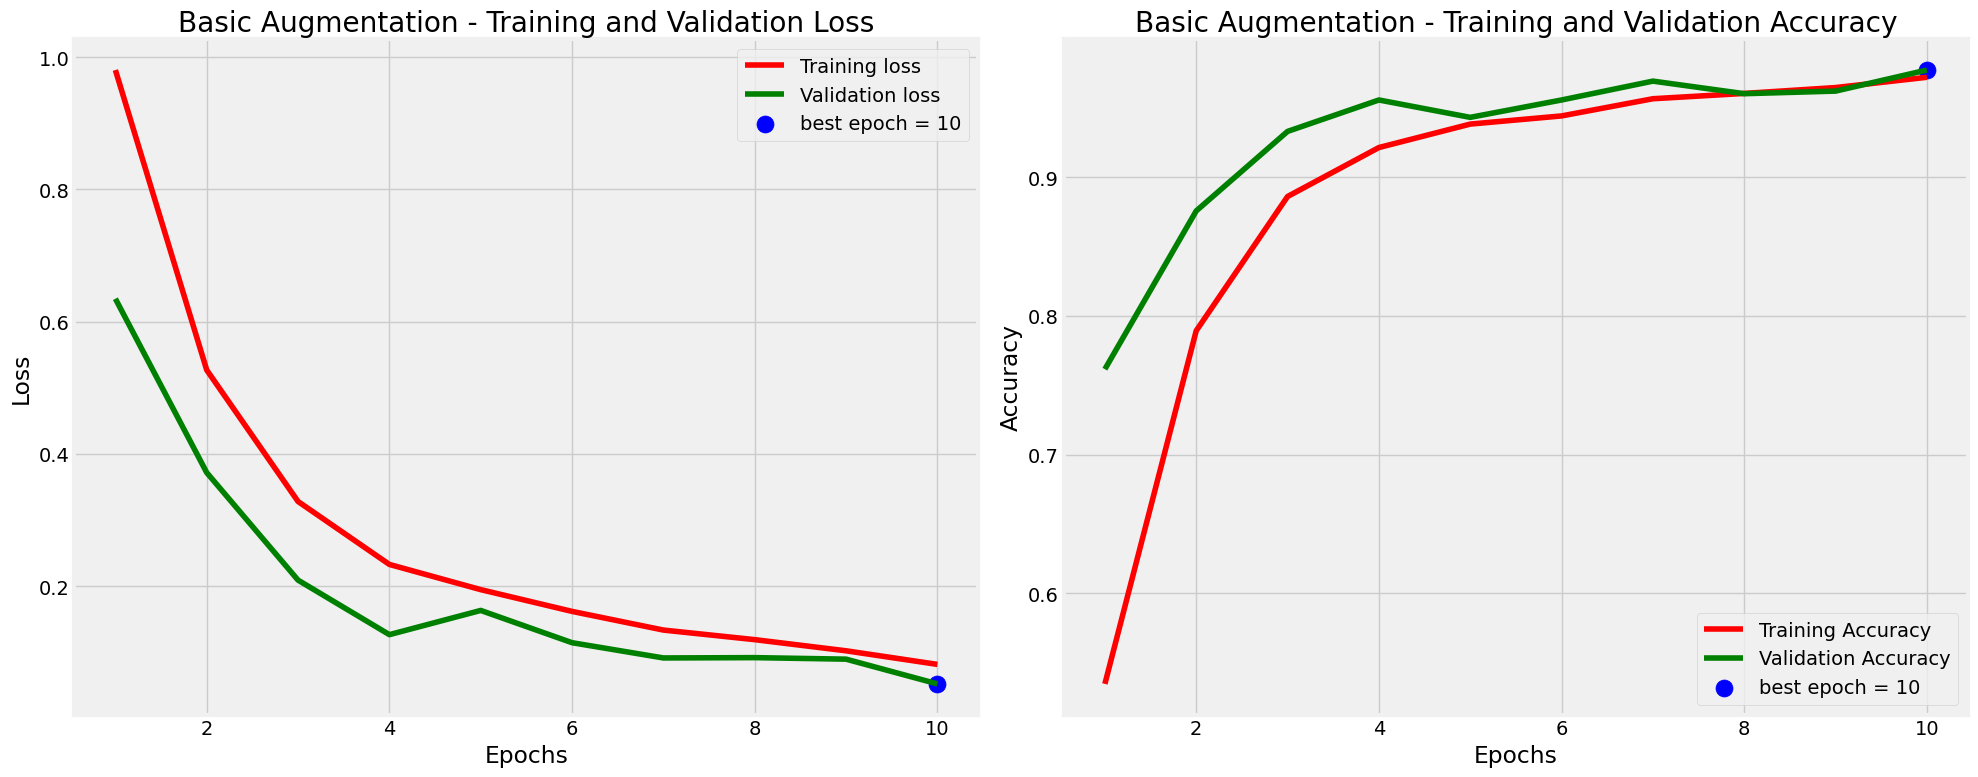

118/118 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step


In [ ]:
hist_basic, metrics_basic = train_and_evaluate_model(model_basic, basic_train_gen, basic_valid_gen, basic_test_gen, 'Basic', epochs=10)

118/118 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step


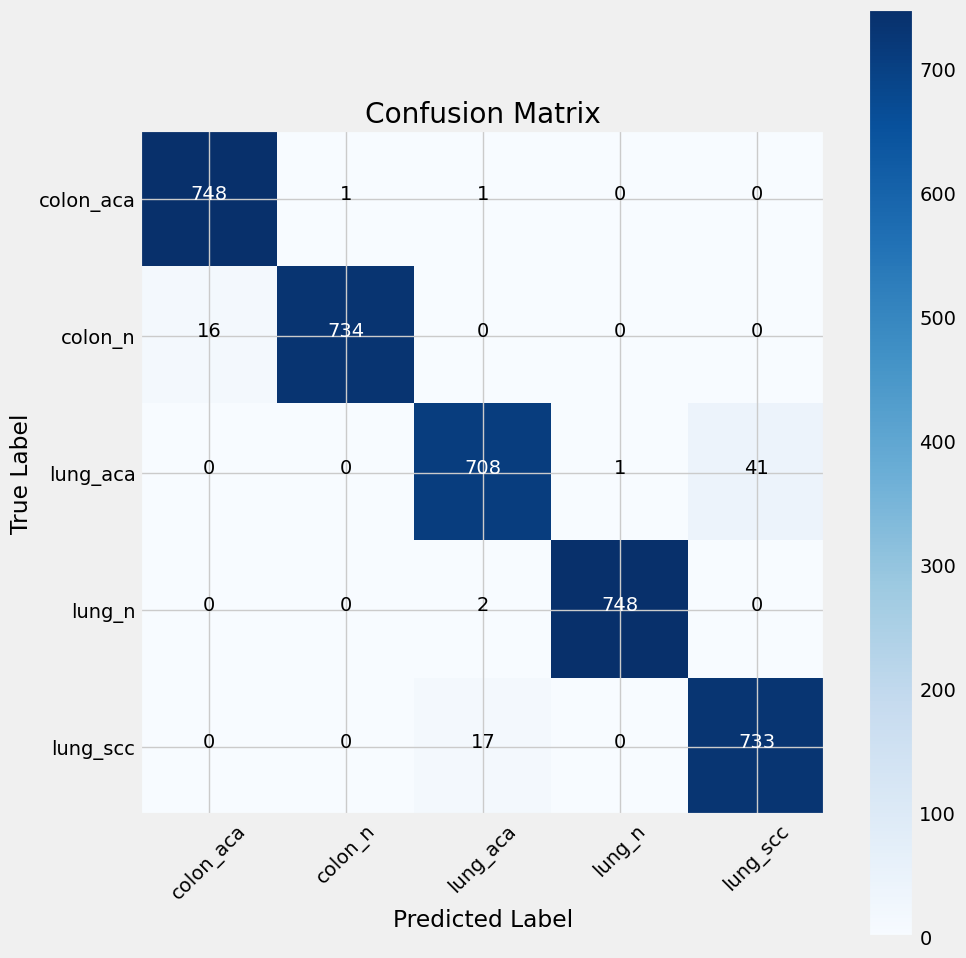

In [ ]:
y_predict_basic = model_basic.predict(basic_test_gen)
confusion_matrix_plot(basic_test_gen, y_predict_basic)

### 5.2.2 Training Moderate Augmentation

In [ ]:
model_moderate = create_model()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,154,245 (80.70 MB)

 Trainable params: 21,154,245 (80.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 238s 422ms/step - accuracy: 0.2651 - loss: 1.5438 - val_accuracy: 0.7269 - val_loss: 0.7322
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 229s 419ms/step - accuracy: 0.7558 - loss: 0.6237 - val_accuracy: 0.8677 - val_loss: 0.3344
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 228s 416ms/step - accuracy: 0.8711 - loss: 0.3759 - val_accuracy: 0.9125 - val_loss: 0.2274
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 228s 417ms/step - accuracy: 0.9200 - loss: 0.2332 - val_accuracy: 0.9395 - val_loss: 0.1490
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 225s 411ms/step - accuracy: 0.9354 - loss: 0.1920 - val_accuracy: 0.9576 - val_loss: 0.1108
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 229s 418ms/step - accuracy: 0.9439 - loss: 0.1706 - val_accuracy: 0.9552 - val_loss: 0.1385
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 226s 412ms/step - accuracy: 0.9498 - loss: 0.1505 - val_accuracy: 0.9528 - val_loss: 0.1294
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 228s 416ms/step - accuracy: 0.9598 -

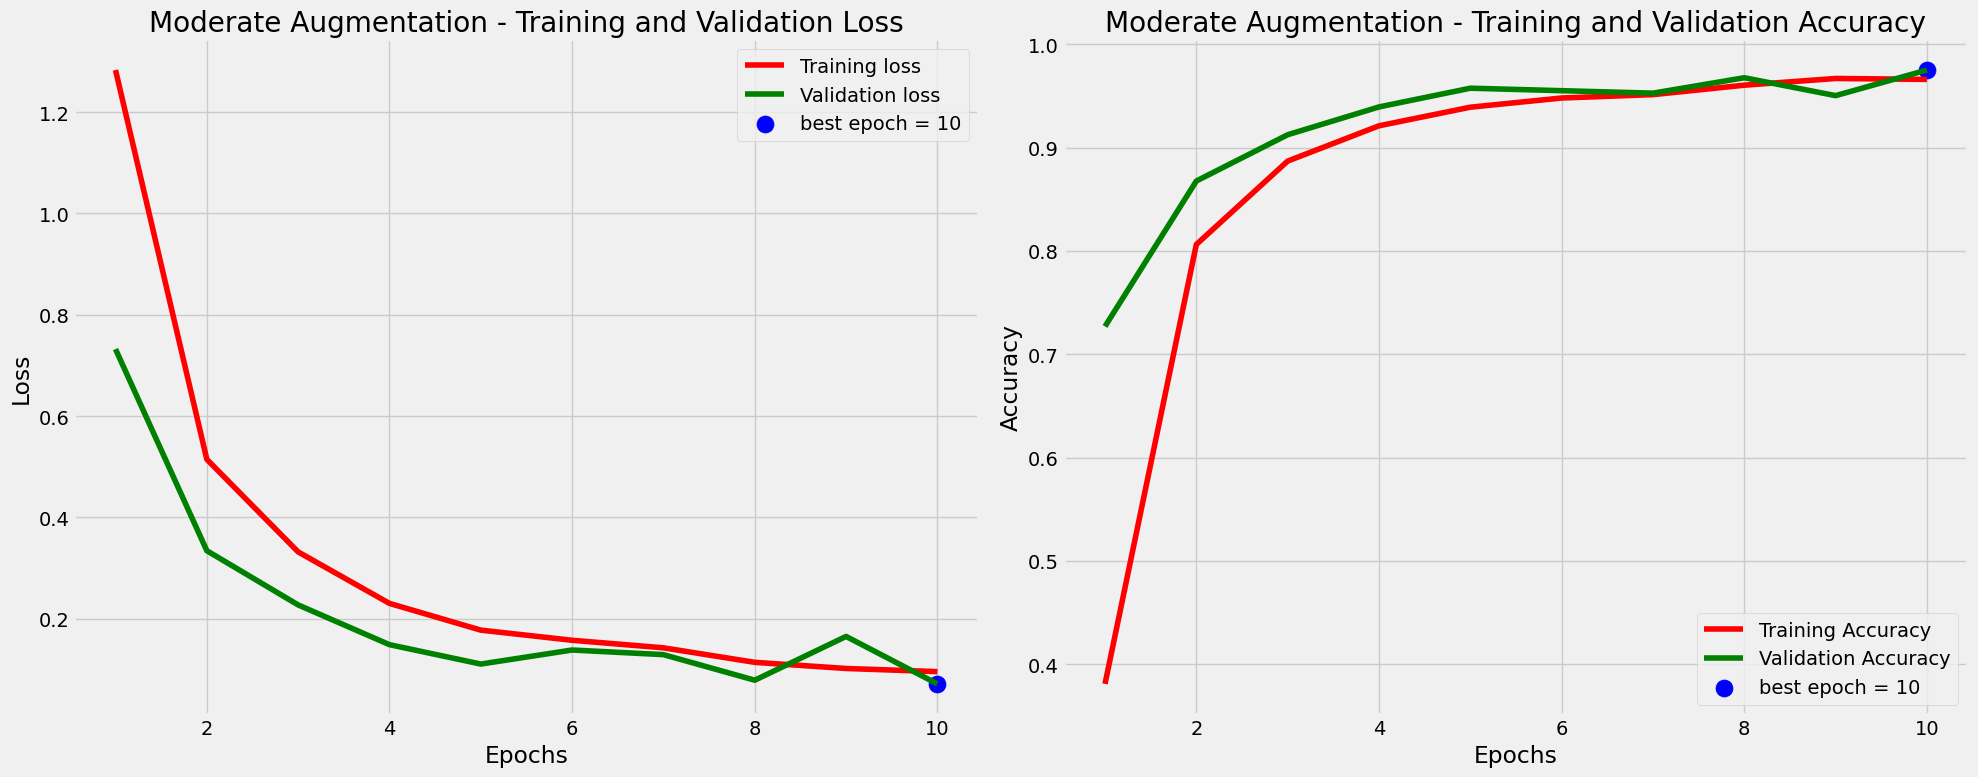

118/118 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step


In [ ]:
hist_moderate, metrics_moderate = train_and_evaluate_model(model_moderate, moderate_train_gen, moderate_valid_gen, moderate_test_gen, "Moderate", epochs= 10)

118/118 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step


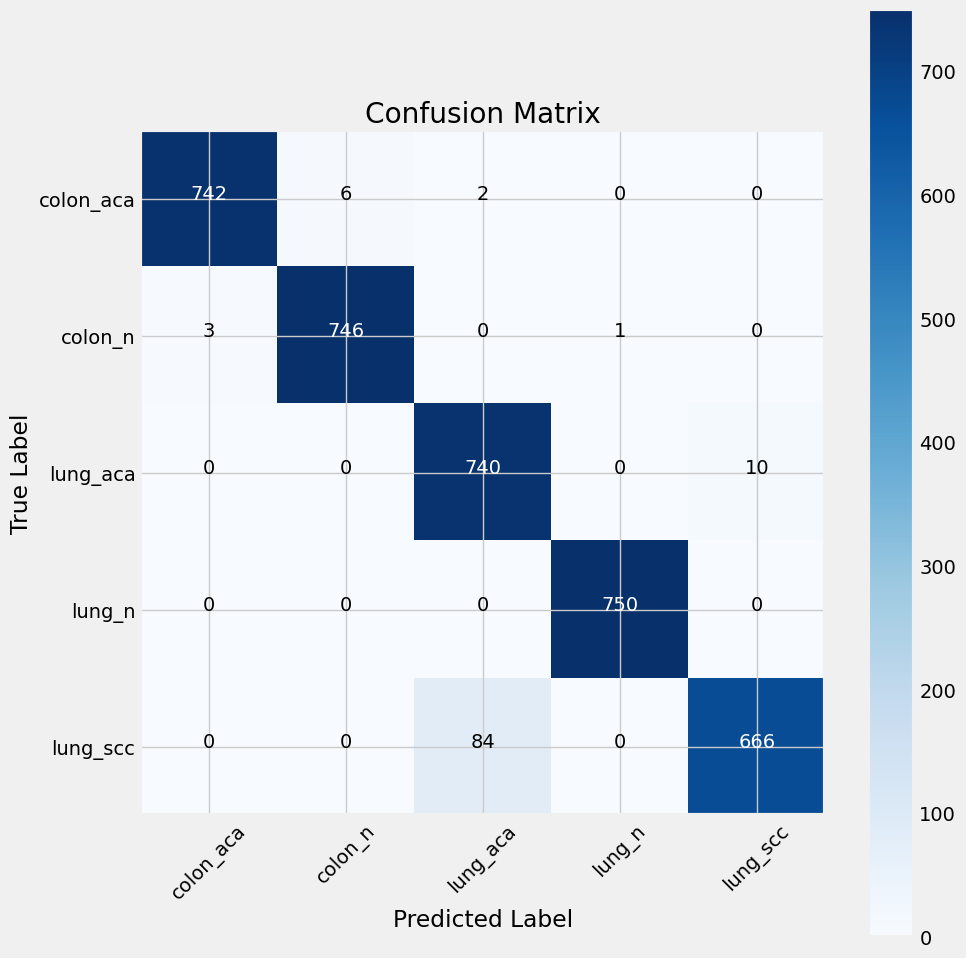

In [ ]:
y_predict_moderate = model_moderate.predict(moderate_test_gen)
confusion_matrix_plot(moderate_test_gen, y_predict_moderate)

### 5.2.3 Training Advanced Augmentation

In [ ]:
model_advanced = create_model()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,154,245 (80.70 MB)

 Trainable params: 21,154,245 (80.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 264s 452ms/step - accuracy: 0.2880 - loss: 1.4554 - val_accuracy: 0.6669 - val_loss: 0.6351
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 227s 415ms/step - accuracy: 0.6956 - loss: 0.6425 - val_accuracy: 0.7968 - val_loss: 0.4793
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 227s 416ms/step - accuracy: 0.8150 - loss: 0.4687 - val_accuracy: 0.9104 - val_loss: 0.2630
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 230s 420ms/step - accuracy: 0.8907 - loss: 0.3088 - val_accuracy: 0.9253 - val_loss: 0.2146
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 226s 413ms/step - accuracy: 0.9242 - loss: 0.2248 - val_accuracy: 0.9363 - val_loss: 0.1809
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 228s 417ms/step - accuracy: 0.9390 - loss: 0.1845 - val_accuracy: 0.9507 - val_loss: 0.1434
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 229s 419ms/step - accuracy: 0.9332 - loss: 0.1952 - val_accuracy: 0.9477 - val_loss: 0.1316
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 227s 414ms/step - accuracy: 0.9500 -

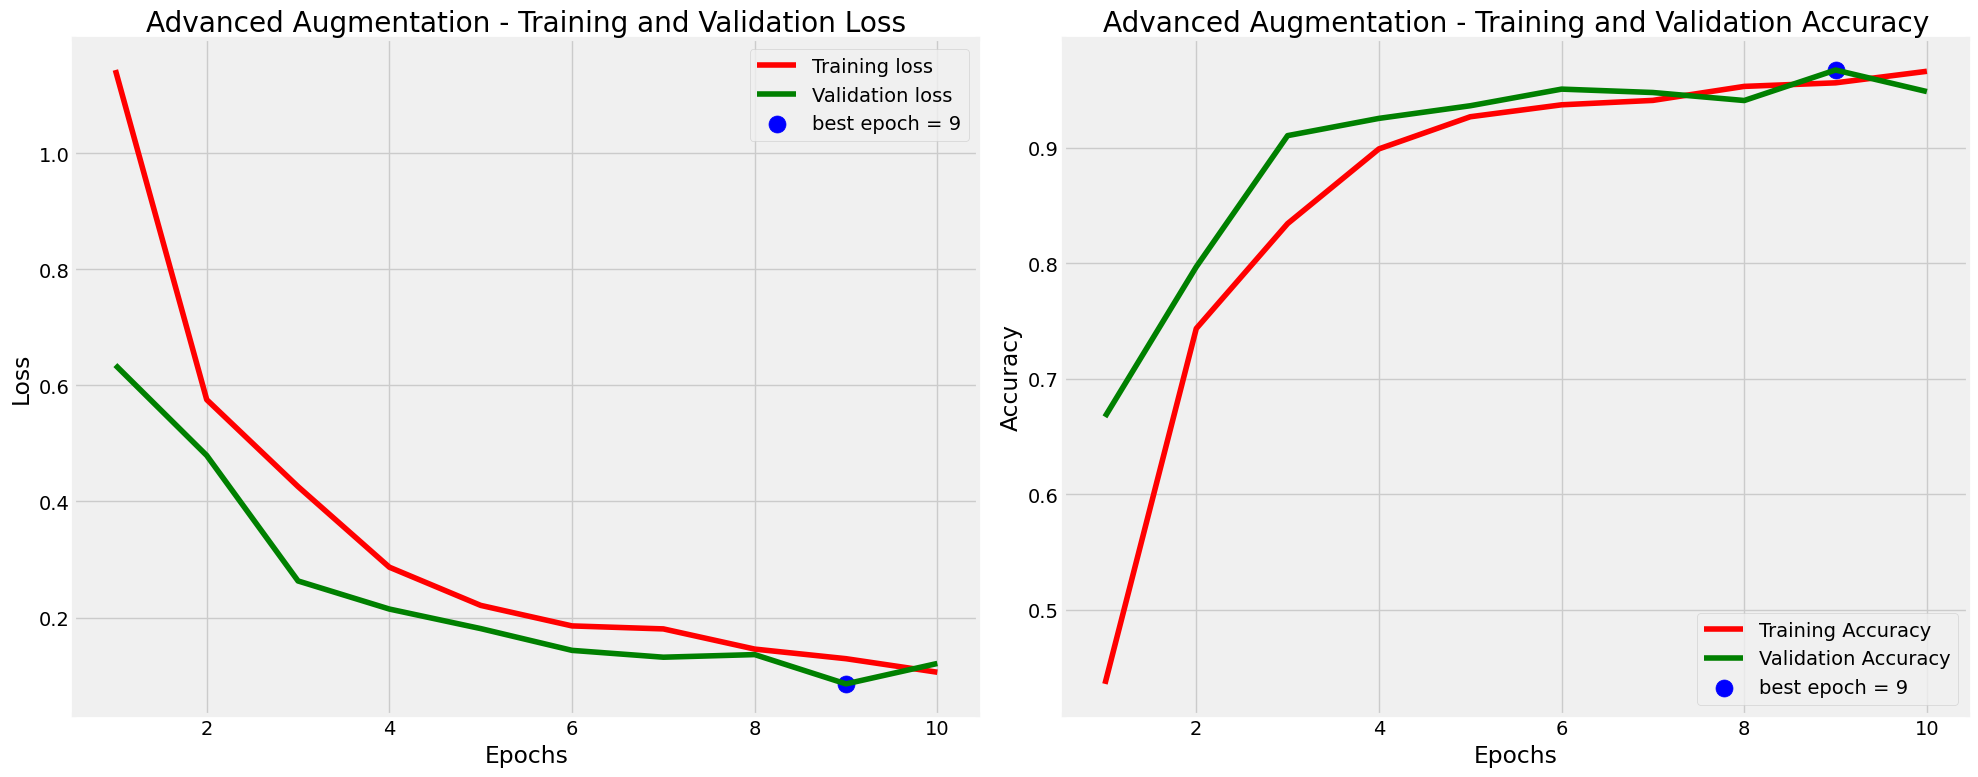

118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step


In [ ]:
hist_advanced, metrics_advanced = train_and_evaluate_model(model_advanced, advanced_train_gen, advanced_valid_gen, advanced_test_gen, "Advanced", epochs=10)

118/118 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step


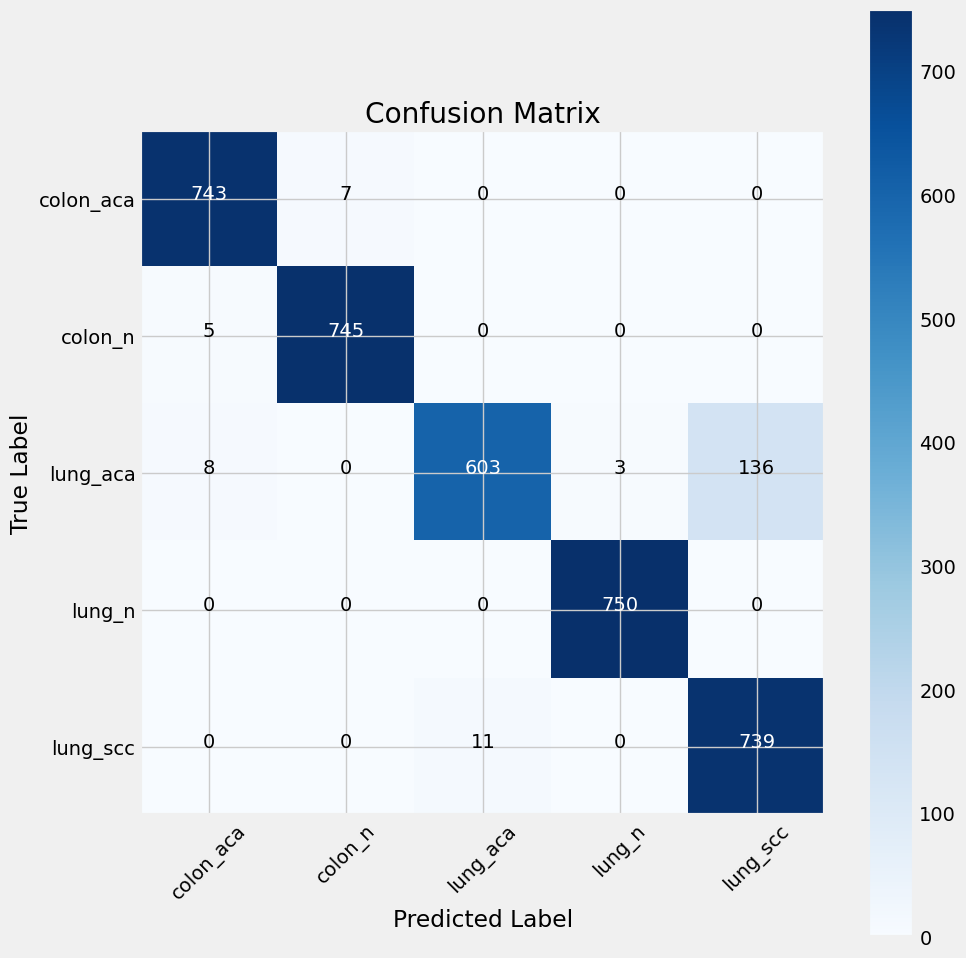

In [ ]:
y_predict_advanced = model_advanced.predict(advanced_test_gen)
confusion_matrix_plot(advanced_test_gen, y_predict_advanced)

# Evaluation

In [ ]:
print(metrics_basic)

{'best_val_loss': 0.05220028758049011, 'best_val_loss_epoch': 10, 'best_val_acc': 0.9773333072662354, 'best_val_acc_epoch': 10, 'test_precision': 0.9791835660441571, 'test_recall': 0.9789333333333333, 'test_f1': 0.9789310993438171}


In [ ]:
print(metrics_moderate)

{'best_val_loss': 0.0716463029384613, 'best_val_loss_epoch': 10, 'best_val_acc': 0.9751999974250793, 'best_val_acc_epoch': 10, 'test_precision': 0.9735507501733632, 'test_recall': 0.9717333333333333, 'test_f1': 0.9716971538351729}


In [ ]:
print(metrics_advanced)

{'best_val_loss': 0.08558563888072968, 'best_val_loss_epoch': 9, 'best_val_acc': 0.967199981212616, 'best_val_acc_epoch': 9, 'test_precision': 0.9592335555092181, 'test_recall': 0.9546666666666667, 'test_f1': 0.9540874232816625}
